In [1]:
import tensorflow as tf
import numpy as np

In [2]:
import os
import dataloader

In [3]:
import matplotlib.pyplot as plt
import nibabel as nib
import cv2

In [4]:
from importlib import reload

In [32]:
ROOT_DIR = '.'
DATA_DIR = 'BRATS_2018'
LABELED_DIR = 'MICCAI_BraTS_2018_Data_Training'
UNLABELED_DIR = 'MICCAI_BraTS_2018_Data_Validation'
LABELED_PATH = os.path.join(ROOT_DIR, DATA_DIR, LABELED_DIR)
UNLABELED_PATH = os.path.join(ROOT_DIR, DATA_DIR, UNLABELED_DIR)

BATCH_SIZE = 32
BRAIN_SLICES = 8
NUM_CLASSES = 4
X_DTYPE = np.float32
Y_DTYPE = np.float32
MAX_VALUE = 32767

In [6]:
paths, sizes = dataloader.load_dataset_paths(LABELED_PATH, UNLABELED_PATH)

In [7]:
train_brains, val_brains, test_brains, unlabeled_brains = paths

In [8]:
hgg_train_size, lgg_train_size, hgg_val_size, lgg_val_size = sizes 

In [9]:
hgg_train_size, lgg_train_size

(142, 50)

In [12]:
# Zamienić 4 na 3!!! Istnieją realnie tylko 4 klasy (0, 1, 2, 4)

In [23]:
elo = nib.load(f'{dataloader.extend_path_from_last_part(train_brains[0])}_seg.nii').get_fdata()[:, :, 75]

In [10]:
siema = np.zeros((128, 128), dtype=np.int8)

In [11]:
siema[:, :] = cv2.resize(elo, (128, 128))

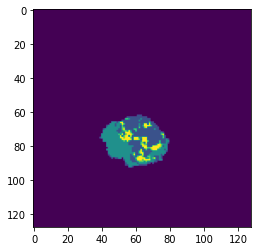

In [20]:
plt.imshow(siema)
plt.show()

In [12]:
LABEL_MAPPING_PATTERN = {0: 0, 2: 1, 4: 2, 1: 3}
def _map_labels(arr):
    u, inv = np.unique(arr, return_inverse=True)
    return np.array([LABEL_MAPPING_PATTERN[x] for x in u], dtype=np.uint8)[inv].reshape(arr.shape)

In [14]:
np.unique(siema)

array([0, 1, 2, 3, 4], dtype=int8)

[0 1 2 3]


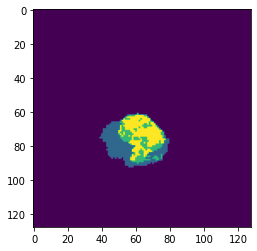

In [42]:
siema = np.zeros((128, 128), dtype=np.uint8)
elo2 = _map_labels(elo)
print(np.unique(elo2))
siema[:, :] = cv2.resize(elo2, (128, 128))[:, :]
plt.imshow(siema)
plt.show()

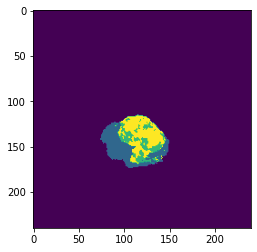

In [33]:
plt.imshow(elo2)
plt.show()

In [32]:
np.unique(elo2)

array([0, 1, 2, 3])

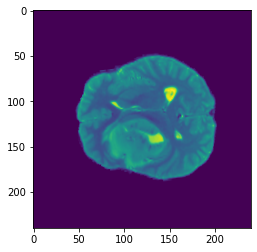

In [17]:
plt.imshow(nib.load(f'{dataloader.extend_path_from_last_part(train_brains[0])}_t2.nii').get_fdata()[:, :, 75])
plt.show()

In [11]:
for path in test_brains:
    print(np.unique(nib.load(f'{dataloader.extend_path_from_last_part(path)}_seg.nii').get_fdata()))

[0. 1. 2. 4.]
[0. 1. 2. 4.]
[0. 1. 2. 4.]
[0. 1. 2. 4.]
[0. 1. 2. 4.]
[0. 1. 2. 4.]
[0. 1. 2. 4.]
[0. 1. 2. 4.]
[0. 1. 2. 4.]
[0. 1. 2. 4.]
[0. 1. 2. 4.]
[0. 1. 2. 4.]
[0. 1. 2. 4.]
[0. 1. 2. 4.]
[0. 1. 2. 4.]
[0. 1. 2. 4.]
[0. 1. 2. 4.]
[0. 1. 2. 4.]
[0. 1. 2. 4.]
[0. 1. 2. 4.]
[0. 1. 2. 4.]
[0. 1. 2. 4.]
[0. 1. 2. 4.]
[0. 1. 2. 4.]
[0. 1. 2. 4.]
[0. 1. 2. 4.]
[0. 1. 2. 4.]
[0. 1. 2. 4.]
[0. 1. 2. 4.]
[0. 1. 2. 4.]
[0. 1. 2. 4.]
[0. 1. 2. 4.]
[0. 1. 2.]
[0. 1. 2.]
[0. 1. 2. 4.]
[0. 1. 2. 4.]
[0. 1. 2.]
[0. 1. 2. 4.]
[0. 1. 2. 4.]
[0. 1. 2.]
[0. 1. 2.]
[0. 1. 2. 4.]
[0. 1. 2.]
[0. 1. 2. 4.]


In [7]:
len(train_brains), len(val_brains), len(test_brains), len(unlabeled_brains)

(192, 49, 44, 66)

In [6]:
all_brains = train_brains + val_brains + test_brains + unlabeled_brains

In [43]:
reload(dataloader)
import dataloader

In [36]:
dataloader.find_max_per_channel(all_brains)

{'t1': 32767.0, 't1ce': 32767.0, 't2': 32767.0, 'flair': 32767.0}

In [35]:
w_low_path = '.\\BRATS_2018\\MICCAI_BraTS_2018_Data_Training\\LGG\\Brats18_TCIA13_654_1\\Brats18_TCIA13_654_1_t1.nii'

In [36]:
h_low_high_path = '.\\BRATS_2018\\MICCAI_BraTS_2018_Data_Validation\\Brats18_CBICA_AZA_1\\Brats18_CBICA_AZA_1_t1.nii'

In [37]:
w_high_path = '.\\BRATS_2018\\MICCAI_BraTS_2018_Data_Validation\\Brats18_UAB_3454_1\\Brats18_UAB_3454_1_t1.nii'

In [16]:
def load_and_resize(path):
    data = nib.load(path).get_fdata()[:, :, 75]
    return cv2.resize(data, (dataloader.IMAGE_SIZE, dataloader.IMAGE_SIZE))

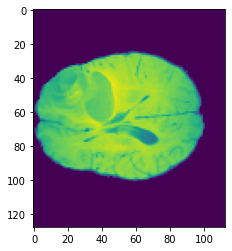

In [42]:
img = load_and_resize(w_low_path)
plt.imshow(img[:, 15:])

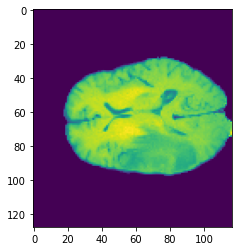

In [45]:
img = load_and_resize(w_high_path)
plt.imshow(img[:, :117])

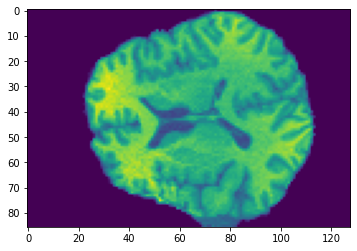

In [46]:
img = load_and_resize(h_low_high_path)
plt.imshow(img[20:106, :])

In [49]:
cutted = cutter.transform(img)

In [51]:
cutted.shape

(86, 102)

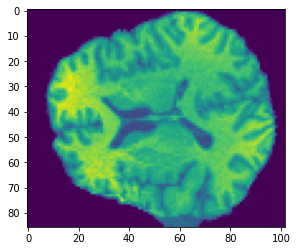

In [50]:
plt.imshow(cutted)

In [23]:
reload(dataloader)
import dataloader

In [24]:
train_dataset = tf.data.Dataset.from_generator(dataloader.build_data_generator, output_signature=(
    tf.TensorSpec(shape=(BATCH_SIZE, dataloader.IMAGE_SIZE, dataloader.IMAGE_SIZE, dataloader.CHANNELS), dtype=X_DTYPE),
    tf.TensorSpec(shape=(BATCH_SIZE, dataloader.IMAGE_SIZE, dataloader.IMAGE_SIZE, NUM_CLASSES), dtype=Y_DTYPE)
), args=[train_brains, MAX_VALUE, hgg_train_size, lgg_train_size])

In [25]:
val_dataset = tf.data.Dataset.from_generator(dataloader.build_data_generator, output_signature=(
    tf.TensorSpec(shape=(BATCH_SIZE, dataloader.IMAGE_SIZE, dataloader.IMAGE_SIZE, dataloader.CHANNELS), dtype=X_DTYPE),
    tf.TensorSpec(shape=(BATCH_SIZE, dataloader.IMAGE_SIZE, dataloader.IMAGE_SIZE, NUM_CLASSES), dtype=Y_DTYPE)
), args=[val_brains, MAX_VALUE, hgg_val_size, lgg_val_size])

In [26]:
type(train_dataset)

tensorflow.python.data.ops.flat_map_op._FlatMapDataset

In [27]:
train_dataset = train_dataset.repeat().prefetch(tf.data.AUTOTUNE)

In [28]:
val_dataset = val_dataset.repeat().prefetch(tf.data.AUTOTUNE)

In [14]:
type(train_dataset)

tensorflow.python.data.ops.prefetch_op._PrefetchDataset

0
1
(128, 128)
CacheInfo(hits=69, misses=155, maxsize=32, currsize=32)


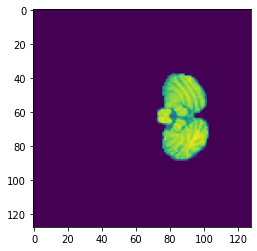

In [65]:
for elem in val_dataset.take(1):
    plt.imshow(elem[0][0, :, :, 0])
    elo = elem[0][0, :, :, 0]
    print(elo.shape)

In [14]:
import architecture

In [71]:
model = architecture.build_model((dataloader.IMAGE_SIZE, dataloader.IMAGE_SIZE, dataloader.CHANNELS), NUM_CLASSES, 'relu', 'he_normal')

In [30]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 96, 112, 4)]         0         []                            
                                                                                                  
 sequential_15 (Sequential)  (None, 96, 112, 16)          2480      ['input_4[0][0]']             
                                                                                                  
 inception_module_12 (Incep  (None, 48, 56, 16)           824       ['sequential_15[0][0]']       
 tionModule)                                                                                      
                                                                                                  
 sequential_16 (Sequential)  (None, 48, 56, 32)           38176     ['inception_module_12[0]

In [ ]:
import metrics

In [72]:
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Nadam(), metrics=['accuracy', 
                                                                                               tf.keras.metrics.OneHotMeanIoU(num_classes=NUM_CLASSES),
                                                                                               tf.keras.metrics.OneHotIoU(num_classes=NUM_CLASSES, target_class_ids=[0]),
                                                                                               tf.keras.metrics.OneHotIoU(num_classes=NUM_CLASSES, target_class_ids=[1]),
                                                                                               tf.keras.metrics.OneHotIoU(num_classes=NUM_CLASSES, target_class_ids=[2]),
                                                                                               tf.keras.metrics.OneHotIoU(num_classes=NUM_CLASSES, target_class_ids=[3]),
                                                                                               metrics.weighted_f1,
                                                                                               tf.keras.metrics.Precision(class_id=0),
                                                                                               tf.keras.metrics.Precision(class_id=1),
                                                                                               tf.keras.metrics.Precision(class_id=2),
                                                                                               tf.keras.metrics.Precision(class_id=3),
                                                                                               tf.keras.metrics.Recall(class_id=0),
                                                                                               tf.keras.metrics.Recall(class_id=1),
                                                                                               tf.keras.metrics.Recall(class_id=2),
                                                                                               tf.keras.metrics.Recall(class_id=3)])

In [73]:
history = model.fit(train_dataset, epochs=1, steps_per_epoch=3, validation_data=val_dataset, validation_steps=3)

3/3 [==============================] - 113s 36s/step - loss: 1.3674 - accuracy: 0.6981 - one_hot_mean_io_u_11: 0.1778 - one_hot_io_u_1: 0.6988 - one_hot_io_u_2: 0.0085 - one_hot_io_u_3: 0.0025 - one_hot_io_u_4: 0.0014 - weighted_f1: 0.3998 - precision_16: 0.0000e+00 - precision_17: 0.0000e+00 - precision_18: 0.0000e+00 - precision_19: 0.0000e+00 - recall_16: 0.0000e+00 - recall_17: 0.0000e+00 - recall_18: 0.0000e+00 - recall_19: 0.0000e+00 - val_loss: 1.0559 - val_accuracy: 0.8882 - val_one_hot_mean_io_u_11: 0.2227 - val_one_hot_io_u_1: 0.8888 - val_one_hot_io_u_2: 0.0000e+00 - val_one_hot_io_u_3: 0.0000e+00 - val_one_hot_io_u_4: 0.0022 - val_weighted_f1: 0.5166 - val_precision_16: 0.9069 - val_precision_17: 0.0000e+00 - val_precision_18: 0.0000e+00 - val_precision_19: 0.0000e+00 - val_recall_16: 0.0056 - val_recall_17: 0.0000e+00 - val_recall_18: 0.0000e+00 - val_recall_19: 0.0000e+00


Po zmianie normalizacji

In [44]:
history = model.fit(train_dataset, epochs=1, steps_per_epoch=len(train_brains) * (dataloader.BRAIN_FRAMES//BATCH_SIZE), validation_data=val_dataset)

Epoch 1/2
768/768 [==============================] - 3951s 5s/step - loss: 0.1080 - accuracy: 0.9780 - val_loss: 0.1126 - val_accuracy: 0.9794
Epoch 2/2
768/768 [==============================] - 169s 220ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - val_loss: 0.1126 - val_accuracy: 0.9794


In [52]:
history = model.fit(train_dataset, epochs=2, steps_per_epoch=len(train_brains) * (dataloader.BRAIN_FRAMES//BATCH_SIZE), validation_data=val_dataset, workers=2)

Epoch 1/2
768/768 [==============================] - 4172s 5s/step - loss: 0.0889 - accuracy: 0.9795 - val_loss: 0.0869 - val_accuracy: 0.9794
Epoch 2/2
768/768 [==============================] - 4078s 5s/step - loss: 0.0872 - accuracy: 0.9794 - val_loss: 0.0964 - val_accuracy: 0.9794


Przed zmianą normalizacji

In [21]:
history = model.fit(train_dataset, epochs=3, steps_per_epoch=len(train_brains) * (dataloader.BRAIN_FRAMES//32), validation_data=val_dataset, workers=2)

Epoch 1/3
912/912 [==============================] - 4568s 5s/step - loss: 0.0961 - accuracy: 0.9782 - val_loss: 0.0924 - val_accuracy: 0.9782
Epoch 2/3
912/912 [==============================] - 188s 206ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - val_loss: 0.0924 - val_accuracy: 0.9782


In [22]:
model.evaluate(val_dataset)

228/228 [==============================] - 195s 854ms/step - loss: 0.0924 - accuracy: 0.9782


[0.09240186959505081, 0.9781610369682312]